## Introduction
This work was originally forked from [David List's Notebook](https://www.kaggle.com/code/davidlist/experiment-ts-6-4-visualization), which is where the nice visualisations came from.  Thanks to David for this. I found the various public visualisation notebooks super helpful.

My goal with this notebook was to a little more EDA to get a feel for the data, and pre-process the tomograms into smaller chunks around the label centroids from which I plan to build my own models.

I have also adding an 'empty' class, by randomly sampling from the remaining volume.

**Update 30 January 2025**  
I am still using this strategy, it is working OK but not as well as I had hoped.  I settled on 32x32x32 crops for my models.  I have updated this notebook to save the data in uint8 datatype.  At some point I realised that I had handicapped my models by working in float32, making them really slow.  It was a hard lesson in the importance of paying attention to efficient data use!

In [1]:
!pip install zarr

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 59.2 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=963e05e77813f8b074f46922c0407ff0cfc50b608e18ec29a294547c7599ef8e
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
from pathlib import Path
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zarr

In [3]:
class NotebookConfig:
    CROP_SIZE = 16
    NUM_EMPTY = 500
    OBJECT_RADII_A = {'apo-ferritin': 60, 
                      'beta-amylase': 65, 
                      'beta-galactosidase': 90, 
                      'ribosome': 150,
                      'thyroglobulin':130,
                      'virus-like-particle':135}
    ZARR_SCALE = 10.012444  #Maps the pixel scale to the physical scale in Angstroms.  Found in the .zarr attributes file.
    def __init__(self):
        self.OBJECT_RADII_VOX  = {name: int(round(rad / self.ZARR_SCALE))
                                  for name, rad in self.OBJECT_RADII_A.items()}

class Paths:
    def __init__(self, data_fldr, results_fldr):
        _czii =  'czii-cryo-et-object-identification'
        self.RESULTS_FLDR = results_fldr
        self.TRAIN_FLDR = data_fldr / f'{_czii}/train'
        self.TRAIN_LABELS_FLDR = self.TRAIN_FLDR / 'overlay/ExperimentRuns'
        self.TRAIN_ZARS_FLDR = self.TRAIN_FLDR / 'static/ExperimentRuns'
        self.TEST_ZARS_FLDR = data_fldr / f'{_czii}/test/static/ExperimentRuns'
        self.TEST_NMS = [fldr.name for fldr in self.TEST_ZARS_FLDR.iterdir()]
        self.TRAIN_NMS = [fldr.name for fldr in self.TRAIN_ZARS_FLDR.iterdir()]

        self.TYPES = ['apo-ferritin', 
                      'beta-amylase', 
                      'beta-galactosidase', 
                      'ribosome',
                      'thyroglobulin',
                      'virus-like-particle']

        _all_classes = self.TYPES + ['empty']
        _label_rel_pths = {name : f'Picks/{name}.json' for name in self.TYPES}
        _label_fldrs = [p for p in self.TRAIN_LABELS_FLDR.iterdir()]
        self.DESTN_FLDRS  = {particle_type: self.RESULTS_FLDR / particle_type for particle_type in _all_classes}
        [dir_path.mkdir(parents=True, exist_ok=True) for dir_path in self.DESTN_FLDRS.values()]

        self.LABELS = {sub_dir.name: {key: str(sub_dir / val) for key, val in _label_rel_pths.items()}
                        for sub_dir in _label_fldrs if sub_dir.is_dir()}
        
        self.TRAIN_DN_ZARS =  {dir_path.name: self.TRAIN_ZARS_FLDR / 
                               f'{dir_path.name}/VoxelSpacing10.000/denoised.zarr'
                                for dir_path in self.TRAIN_ZARS_FLDR.iterdir()}
        self.TRAIN_DCON_ZARS =  {dir_path.name: self.TRAIN_ZARS_FLDR / 
                               f'{dir_path.name}/VoxelSpacing10.000/ctfdeconvolved.zarr'
                                for dir_path in self.TRAIN_ZARS_FLDR.iterdir()}
        self.TRAIN_ISO_ZARS =  {dir_path.name: self.TRAIN_ZARS_FLDR / 
                               f'{dir_path.name}/VoxelSpacing10.000/isonetcorrected.zarr'
                                for dir_path in self.TRAIN_ZARS_FLDR.iterdir()}
        self.TRAIN_WBP_ZARS =  {dir_path.name: self.TRAIN_ZARS_FLDR / 
                                f'{dir_path.name}/VoxelSpacing10.000/wbp.zarr'
                                for dir_path in self.TRAIN_ZARS_FLDR.iterdir()}

        print(f'Test Folders: {self.TEST_NMS}')
        print(f'Train Folders: {self.TRAIN_NMS}\n')
        _denoised_files = [f'{f.parent.parent.name}/{f.parent.name}/{f.name}'
                              for f in self.TRAIN_DN_ZARS.values()]
        print(f'Denoised Train Zarr Files:\n{_denoised_files}')
        print(f"\nLabels for 'TS_6_4':\n{self.LABELS['TS_6_4']}")

input_path = Path('/kaggle/input')
output_path = Path('/kaggle/working')

paths = Paths(input_path, output_path)
cfg = NotebookConfig()

Test Folders: ['TS_6_4', 'TS_5_4', 'TS_69_2']
Train Folders: ['TS_86_3', 'TS_6_6', 'TS_6_4', 'TS_5_4', 'TS_73_6', 'TS_99_9', 'TS_69_2']

Denoised Train Zarr Files:
['TS_86_3/VoxelSpacing10.000/denoised.zarr', 'TS_6_6/VoxelSpacing10.000/denoised.zarr', 'TS_6_4/VoxelSpacing10.000/denoised.zarr', 'TS_5_4/VoxelSpacing10.000/denoised.zarr', 'TS_73_6/VoxelSpacing10.000/denoised.zarr', 'TS_99_9/VoxelSpacing10.000/denoised.zarr', 'TS_69_2/VoxelSpacing10.000/denoised.zarr']

Labels for 'TS_6_4':
{'apo-ferritin': '/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/apo-ferritin.json', 'beta-amylase': '/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/beta-amylase.json', 'beta-galactosidase': '/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/beta-galactosidase.json', 'ribosome': '/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_6_4/Picks/ribosom

## Explore Data dimensions and quantities
### Summary
**Train**
* 7 Scans in total: *TS_5_4*, *TS_6_4*, *TS_6_6*, *TS_69_2*, *TS_73_6*, *TS_86_3*, *TS_99_9*
* TS_6_4 has timensions 630 x 630 x 184  (Highest resolution)
* Labels -Picks in `.json` format with seperate files for each of 6 classes
* The scans in `.zarr` format, with 4 variations: *CTF Deconvolved*, *Denoised*, *IsoNetCorrected*, & *WPB*

**Test Sample**
* 3 Scans only: *TS_5_4*, *TS_6_4*, *TS_69_2*  (All present in the Train collection_
* *Denoised* Only
* No labels

**Labels**
* 1269 total object instances, with class sizes varying from 87 (beta-amylase) to 375 (apo-ferritin)
* Nominal radii ranging from 60 (apo-ferritin) to 150 (ribosome)
* With a voxel size of 10 Angstroms, the above is 6-15 voxel widths.  So could potentially be represented by 16x16x16 blocks.

In [4]:
all_samples = [key for key in paths.LABELS.keys()]
all_types = paths.TYPES
flattened = []
for sample in all_samples:
    for particle_type in all_types: 
        json_path = Path(paths.LABELS[sample][particle_type])
        with json_path.open("r", encoding="utf-8") as file:
            data = json.load(file)['points']
        for point in data:
            new_entry = {}
            new_entry['sample_id'] = sample
            new_entry['object_type'] = particle_type
            new_entry['x'] = point['location']['x']
            new_entry['y'] = point['location']['y']
            new_entry['z'] = point['location']['z']
            new_entry['Size (A)'] = cfg.OBJECT_RADII_A[particle_type]
            new_entry['Size (V)'] = cfg.OBJECT_RADII_VOX[particle_type]
            flattened.append(new_entry)
df = pd.DataFrame(flattened)
df['Vol (V3)'] = round(4  * np.pi * (df['Size (V)']/2)** 3  / 3 ).astype(int)
df.head()

,sample_id,object_type,x,y,z,Size (A),Size (V),Vol (V3)
0,TS_86_3,apo-ferritin,3870.343,4952.714,1261.600,60,6,113
1,TS_86_3,apo-ferritin,4130.897,5422.292,501.860,60,6,113
2,TS_86_3,apo-ferritin,2735.000,4668.447,520.291,60,6,113
3,TS_86_3,apo-ferritin,2649.615,4690.615,600.923,60,6,113
4,TS_86_3,apo-ferritin,2665.353,4810.641,612.019,60,6,113


In [5]:
print(f'There are {len(df)} labelled particles')

There are 1269 labelled particles


Let's consider what would happen if we cropped out cubes of small volume by using these labels, and worked with those instead of uniform patches of the whole volume.  If all these particles were non-contiguous, and I was to crop out just the cube around their centres, what proportion of the total volume would this represent?

In [6]:
total_vol = 630 * 630 * 184
cropped_vol = len(df) * (cfg.CROP_SIZE)**3 
fraction_cropped = cropped_vol / total_vol
fraction_labelled = df['Vol (V3)'].sum() / total_vol
fraction_cropped

0.07117420881396036

In [7]:
fraction_labelled

0.01504139417441695

So with a cube size of 16, we are using 7% the provided volume for cubes in our training dataset.  But only 1.5% of the original volume is nominally occupied by the particles of interest by simplistically modelling the particles as spheres.

If it actually was this simple then we have no trouble finding some extra volume to make an 'empty' class.  However we were told by the competition hosts that the volume is under-labelled.  So there are some potential false negatives to be wary of in this extra space.

One other consideration here, is how much of a gain we can get by masking out the empty space with a first-stage 3d process, like U-net, or Classical convolutional methods, and classifying on a second step.  With 32x32x32, we *only* halve the volume of space to process, and that assumes that points of interest are perfectly recognised by a previous step.  On the other hand, if this second step was a 2d classifier, on for example a slice through the middle of the cube, then the speed gain would be enormous, and there is no need to consider smaller cubes, but we risk throwing away a lot of useful information.

With 16x16x16, we reduce the volume we need to process by a factor of 14.  This ought to be super fast.  We can then be generous with detection thresholds to have excessive proposed particle locations (low precision, high recall), just so long as we have an empty class in the subsequent classifier.

Now let's take a look at potential class imbalance

In [8]:
df['object_type'].value_counts()

object_type
apo-ferritin           375
ribosome               331
thyroglobulin          251
virus-like-particle    113
beta-galactosidase     112
beta-amylase            87
Name: count, dtype: int64

In [9]:
df['sample_id'].value_counts()

sample_id
TS_86_3    225
TS_73_6    217
TS_99_9    208
TS_6_4     193
TS_6_6     143
TS_69_2    143
TS_5_4     140
Name: count, dtype: int64

## Examine the Tomographs

In [10]:
# Load the first zarr.
z_ts_6_4 = zarr.open(str(paths.TRAIN_DN_ZARS['TS_6_4']), mode='r')
z_ts_6_4_iso = zarr.open(str(paths.TRAIN_ISO_ZARS['TS_6_4']), mode='r')
z_ts_6_4_dcon = zarr.open(str(paths.TRAIN_DCON_ZARS['TS_6_4']), mode='r')
z_ts_6_4_wbp = zarr.open(str(paths.TRAIN_WBP_ZARS['TS_6_4']), mode='r')

/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns/TS_6_4/VoxelSpacing10.000/denoised.zarr

In [11]:
print(z_ts_6_4)
print(z_ts_6_4[0].shape)
print(z_ts_6_4[1].shape)
print(z_ts_6_4[2].shape)

<zarr.hierarchy.Group '/' read-only>
(184, 630, 630)
(92, 315, 315)
(46, 158, 158)


Looking only at the high resolution, let's check all the Zarr files are the same size

In [12]:
for path in paths.TRAIN_DN_ZARS.values():
    array = zarr.open(str(path), mode='r')[0]
    print(array.shape)

(184, 630, 630)
(184, 630, 630)
(184, 630, 630)
(184, 630, 630)
(184, 630, 630)
(184, 630, 630)
(184, 630, 630)


### High Resolution
Plot the first image at 100 dpi.  Plot all 184 images in a grid after that.

In [13]:
#fig = plt.figure(figsize=(6.3,6.3))
#_ = plt.imshow(z_ts_6_4[0][0])

Plot the first 25 of...not sure what we're looking at yet.  :)

In [14]:

#fig = plt.figure(figsize=(10,74))
#for i in range(184):
#    ax = plt.subplot(37, 5, i + 1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.imshow(z_ts_6_4[0][i])

### Medium Resolution
Plot the first image at 100 dpi.  Plot all 92 images in a grid after that.

In [15]:
#fig = plt.figure(figsize=(3.15,3.15))
#_ = plt.imshow(z_ts_6_4[1][0])

In [16]:
#fig = plt.figure(figsize=(10,38))
#for i in range(92):
##    ax = plt.subplot(19, 5, i + 1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.imshow(z_ts_6_4[1][i])

### Low Resolution
Plot the first image at 100 dpi.  Plot all 46 images in a grid after that.

In [17]:
#fig = plt.figure(figsize=(1.58,1.58))
#_ = plt.imshow(z_ts_6_4[2][0])

In [18]:
#fig = plt.figure(figsize=(10,20))
#for i in range(46):
#    ax = plt.subplot(10, 5, i + 1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.imshow(z_ts_6_4[2][i])

### Denoised, IsoNet Corrected, CTF Deconvolved, and Weighted Back Projection

Next plot each of the different image types present in the training directories.  This time just one high resolution image each of the same layer.

Text(0.5, 1.0, 'Weighted Back Projection')

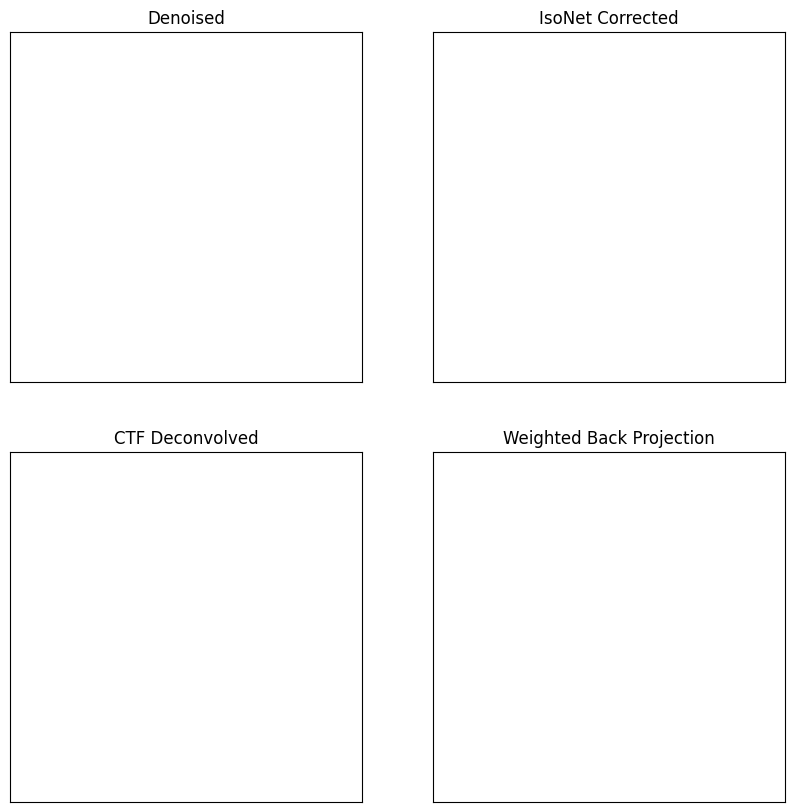

In [19]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2, 2, 1)
plt.xticks([])
plt.yticks([])
plt.title('Denoised')
#plt.imshow(z_ts_6_4[0][62], cmap='gray')
ax = plt.subplot(2, 2, 2)
plt.xticks([])
plt.yticks([])
plt.title('IsoNet Corrected')
#plt.imshow(z_ts_6_4_iso[0][62], cmap='gray')
ax = plt.subplot(2, 2, 3)
plt.xticks([])
plt.yticks([])
plt.title('CTF Deconvolved')
#plt.imshow(z_ts_6_4_dcon[0][62], cmap='gray')
ax = plt.subplot(2, 2, 4)
plt.xticks([])
plt.yticks([])
plt.title('Weighted Back Projection')
#_ = plt.imshow(z_ts_6_4_wbp[0][62], cmap='gray')


### Ribosome Identification

Now that we can plot the images the next step is to try to identify structures of interest.  Lists of those structures for TS_6_4 are in the train/overlay directory.  We'll start with ribosomes.

Find all of the ribosomes between 600 and 650 in the z-axis, and plot them on slide 62 to see if we get something reasonable.  If we do that suggests the origin is in the upper left in the x and y directions, and in the first image in the z direction.

In [20]:
ribosomes_x = []
ribosomes_y = []
f = open(paths.LABELS['TS_6_4']['ribosome'])
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 600 and z < 650:
        ribosomes_x.append(float(p['location']['x'])/10)
        ribosomes_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 5274.903, 'y': 5288.121, 'z': 619.798}
{'x': 5312.439, 'y': 4964.156, 'z': 602.574}
{'x': 5130.837, 'y': 5121.036, 'z': 631.702}
{'x': 5106.838, 'y': 4835.263, 'z': 619.225}
{'x': 1273.648, 'y': 4386.703, 'z': 631.656}
{'x': 440.984, 'y': 3866.177, 'z': 643.857}
{'x': 1015.725, 'y': 640.198, 'z': 622.387}


Looking at the plotted images, we seem to have compelling matches.

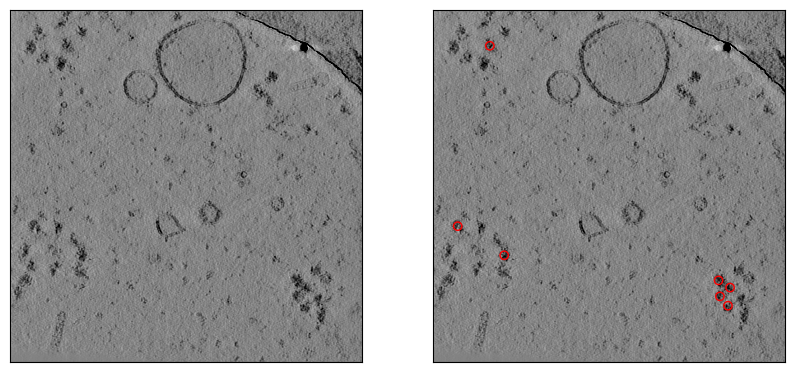

In [21]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][62], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][62], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter(ribosomes_x, ribosomes_y, edgecolor='red', facecolor='none')

### Virus Identification

Repeat the same process for viruses except with a different z-value.

In [22]:
virus_x = []
virus_y = []
f = open(paths.LABELS['TS_6_4']['virus-like-particle'])
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 670 and z < 700:
        virus_x.append(float(p['location']['x'])/10)
        virus_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 911.29, 'y': 5638.402, 'z': 671.21}
{'x': 5580.108, 'y': 1240.86, 'z': 692.222}
{'x': 4765.58, 'y': 3469.964, 'z': 689.813}


Good matches again.

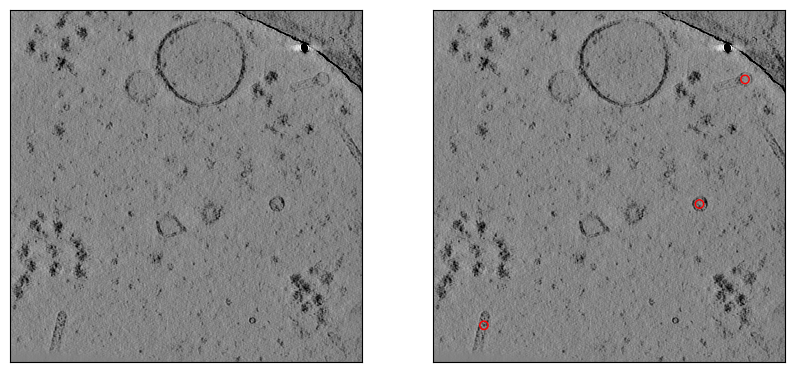

In [23]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][68], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][68], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter(virus_x, virus_y, edgecolor='red', facecolor='none')

### Apo-Ferritin Identification

In [24]:
apo_ferritin_x = []
apo_ferritin_y = []
f = open(paths.LABELS['TS_6_4']['apo-ferritin'])
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 400 and z < 450:
        apo_ferritin_x.append(float(p['location']['x'])/10)
        apo_ferritin_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 1019.831, 'y': 1859.831, 'z': 400.424}
{'x': 3534.854, 'y': 2407.485, 'z': 425.439}
{'x': 3752.045, 'y': 2505.17, 'z': 411.989}
{'x': 3942.417, 'y': 2660.695, 'z': 413.609}
{'x': 4009.57, 'y': 2947.043, 'z': 412.634}
{'x': 4243.778, 'y': 2985.682, 'z': 420.398}
{'x': 3596.958, 'y': 2593.013, 'z': 415.516}
{'x': 3486.946, 'y': 2616.549, 'z': 415.516}
{'x': 3631.179, 'y': 2496.627, 'z': 415.516}


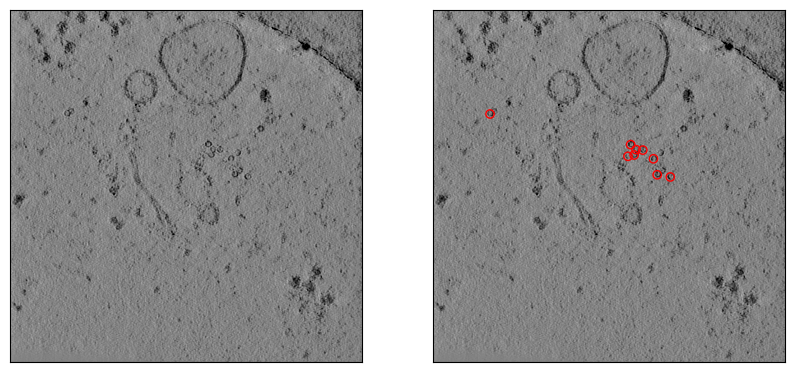

In [25]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][42], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][42], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter(apo_ferritin_x, apo_ferritin_y, edgecolor='red', facecolor='none')

### Beta-Galactosidase Identification

In [26]:
beta_galactosidase_x = []
beta_galactosidase_y = []
f = open(paths.LABELS['TS_6_4']['beta-galactosidase'])
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 450 and z < 500:
        beta_galactosidase_x.append(float(p['location']['x'])/10)
        beta_galactosidase_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 804.615, 'y': 1977.846, 'z': 489.385}
{'x': 4130.0, 'y': 3716.667, 'z': 465.0}


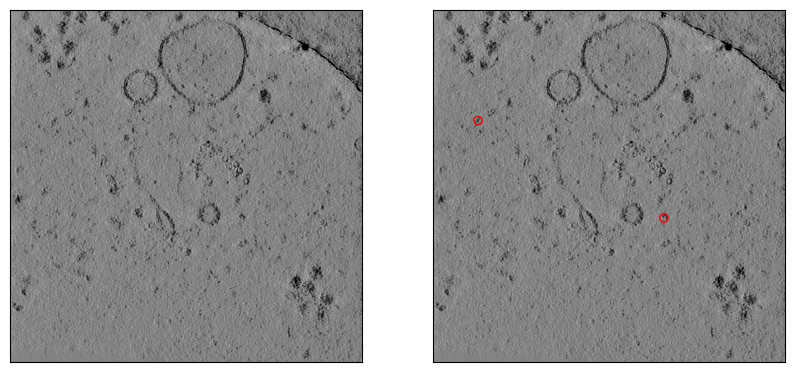

In [27]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][47], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][47], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter(beta_galactosidase_x, beta_galactosidase_y, edgecolor='red', facecolor='none')

### Thyroglobulin Identification

In [28]:
thyroglobulin_x = []
thyroglobulin_y = []
f = open(paths.LABELS['TS_6_4']['thyroglobulin'])
for p in json.loads(f.read())['points']:
    z = float(p['location']['z'])
    if z >= 550 and z < 600:
        thyroglobulin_x.append(float(p['location']['x'])/10)
        thyroglobulin_y.append(float(p['location']['y'])/10)
        print(p['location'])

{'x': 1242.919, 'y': 1464.644, 'z': 581.353}
{'x': 3547.616, 'y': 4770.646, 'z': 595.253}
{'x': 4756.011, 'y': 4447.041, 'z': 581.386}
{'x': 3553.393, 'y': 2129.821, 'z': 561.696}


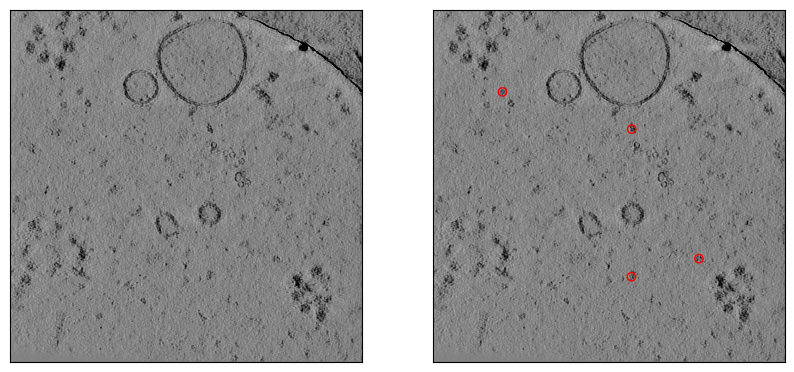

In [29]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][57], cmap='gray', vmin=-0.00005, vmax=0.00005)
ax = plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(z_ts_6_4[0][57], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter(thyroglobulin_x, thyroglobulin_y, edgecolor='red', facecolor='none')

### Ribosome Close-Up

The following are zoomed in images of a ribosome from three perspectives, straight on, from the right side (front is to the left) and from the top (front is to the bottom.)  Somewhat unexpected is the difference in image quality from the sides and top.

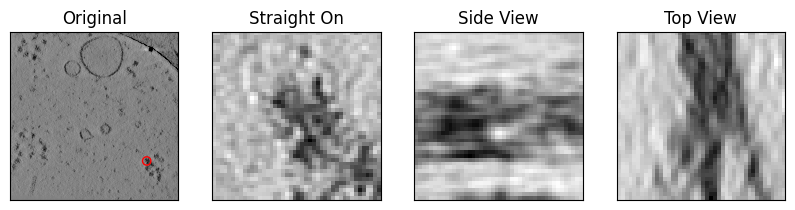

In [30]:
# {'x': 5106.838, 'y': 4835.263, 'z': 619.225}
fig = plt.figure(figsize=(10,2.5))
ax = plt.subplot(1, 4, 1)
plt.xticks([])
plt.yticks([])
plt.title('Original')
plt.imshow(z_ts_6_4[0][61], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter([5106.838/10], [4835.263/10], edgecolor='red', facecolor='none')
ax = plt.subplot(1, 4, 2)
plt.xticks([])
plt.yticks([])
plt.title('Straight On')
plt.imshow(z_ts_6_4[0][61, 461:505, 488:532], cmap='gray')
ax = plt.subplot(1, 4, 3)
plt.xticks([])
plt.yticks([])
plt.title('Side View')
plt.imshow(np.transpose(z_ts_6_4[0], axes=(2,1,0))[510, 461:505, 39:83], cmap='gray')
ax = plt.subplot(1, 4, 4)
plt.xticks([])
plt.yticks([])
plt.title('Top View')
_ = plt.imshow(np.transpose(z_ts_6_4[0], axes=(1,0,2))[483, 39:83, 488:532], cmap='gray')

### Virus Close-Up

Same for virus, although I don't believe this captures the full virus.  In the images above, there is an elongated structure protruding down an to the left.

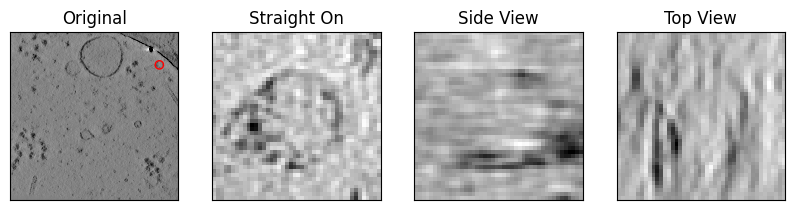

In [31]:
# {'x': 5580.108, 'y': 1240.86, 'z': 692.222}
fig = plt.figure(figsize=(10,2.5))
ax = plt.subplot(1, 4, 1)
plt.xticks([])
plt.yticks([])
plt.title('Original')
plt.imshow(z_ts_6_4[0][69], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter([5580.108/10], [1240.86/10], edgecolor='red', facecolor='none')
ax = plt.subplot(1, 4, 2)
plt.xticks([])
plt.yticks([])
plt.title('Straight On')
plt.imshow(z_ts_6_4[0][69, 102:146, 536:580], cmap='gray')
ax = plt.subplot(1, 4, 3)
plt.xticks([])
plt.yticks([])
plt.title('Side View')
plt.imshow(np.transpose(z_ts_6_4[0], axes=(2,1,0))[558, 102:146, 47:91], cmap='gray')
ax = plt.subplot(1, 4, 4)
plt.xticks([])
plt.yticks([])
plt.title('Top View')
_ = plt.imshow(np.transpose(z_ts_6_4[0], axes=(1,0,2))[124, 47:91, 536:580], cmap='gray')

### Apo-Ferritin Close-Up

Here the particle is difficult to discerne from the side and top.

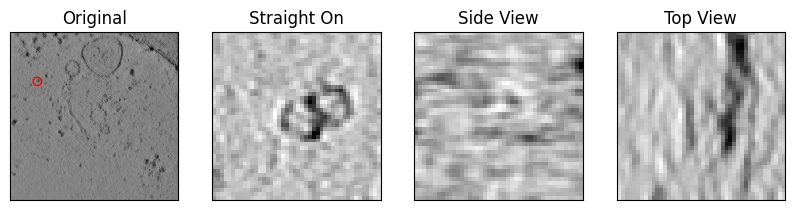

In [32]:
# {'x': 1019.831, 'y': 1859.831, 'z': 400.424}
fig = plt.figure(figsize=(10,2.5))
ax = plt.subplot(1, 4, 1)
plt.xticks([])
plt.yticks([])
plt.title('Original')
plt.imshow(z_ts_6_4[0][40], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter([1019.831/10], [1859.831/10], edgecolor='red', facecolor='none')
ax = plt.subplot(1, 4, 2)
plt.xticks([])
plt.yticks([])
plt.title('Straight On')
plt.imshow(z_ts_6_4[0][40, 163:207, 79:123], cmap='gray')
ax = plt.subplot(1, 4, 3)
plt.xticks([])
plt.yticks([])
plt.title('Side View')
plt.imshow(np.transpose(z_ts_6_4[0], axes=(2,1,0))[101, 163:207, 18:62], cmap='gray')
ax = plt.subplot(1, 4, 4)
plt.xticks([])
plt.yticks([])
plt.title('Top View')
_ = plt.imshow(np.transpose(z_ts_6_4[0], axes=(1,0,2))[185, 18:62, 79:123], cmap='gray')

### Beta-Galactosidase Close-Up

Same for beta-galactosidase.

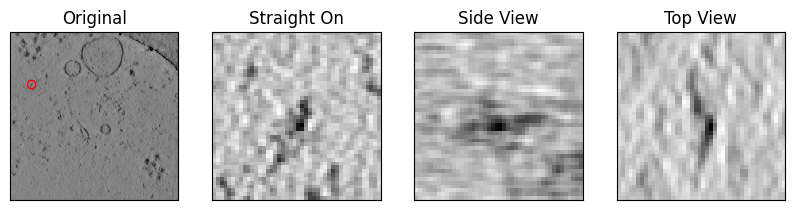

In [33]:
# {'x': 804.615, 'y': 1977.846, 'z': 489.385}
fig = plt.figure(figsize=(10,2.5))
ax = plt.subplot(1, 4, 1)
plt.xticks([])
plt.yticks([])
plt.title('Original')
plt.imshow(z_ts_6_4[0][48], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter([804.615/10], [1977.846/10], edgecolor='red', facecolor='none')
ax = plt.subplot(1, 4, 2)
plt.xticks([])
plt.yticks([])
plt.title('Straight On')
plt.imshow(z_ts_6_4[0][48, 175:219, 58:102], cmap='gray')
ax = plt.subplot(1, 4, 3)
plt.xticks([])
plt.yticks([])
plt.title('Side View')
plt.imshow(np.transpose(z_ts_6_4[0], axes=(2,1,0))[80, 175:219, 26:70], cmap='gray')
ax = plt.subplot(1, 4, 4)
plt.xticks([])
plt.yticks([])
plt.title('Top View')
_ = plt.imshow(np.transpose(z_ts_6_4[0], axes=(1,0,2))[197, 26:70, 58:102], cmap='gray')

### Thyroglobulin Close-Up

Same for thyroglobulin.

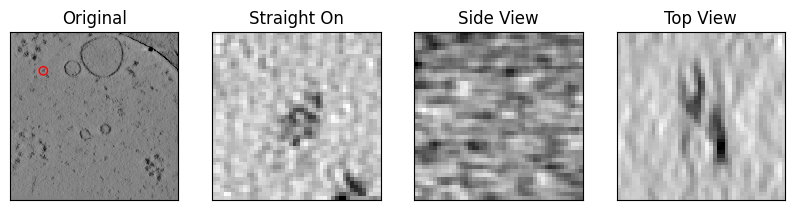

In [34]:
# {'x': 1242.919, 'y': 1464.644, 'z': 581.353}
fig = plt.figure(figsize=(10,2.5))
ax = plt.subplot(1, 4, 1)
plt.xticks([])
plt.yticks([])
plt.title('Original')
plt.imshow(z_ts_6_4[0][58], cmap='gray', vmin=-0.00005, vmax=0.00005)
_ = plt.scatter([1242.919/10], [1464.644/10], edgecolor='red', facecolor='none')
ax = plt.subplot(1, 4, 2)
plt.xticks([])
plt.yticks([])
plt.title('Straight On')
_ = plt.scatter([1242.919/10], [1464.644/10], edgecolor='red', facecolor='none')
plt.imshow(z_ts_6_4[0][58, 124:168, 102:146], cmap='gray')
ax = plt.subplot(1, 4, 3)
plt.xticks([])
plt.yticks([])
plt.title('Side View')
plt.imshow(np.transpose(z_ts_6_4[0], axes=(2,1,0))[124, 175:219, 36:80], cmap='gray')
ax = plt.subplot(1, 4, 4)
plt.xticks([])
plt.yticks([])
plt.title('Top View')
_ = plt.imshow(np.transpose(z_ts_6_4[0], axes=(1,0,2))[146, 36:80, 102:146], cmap='gray')

### Low Res from the Side

Here is the low resolution version plotted from the rigth side moving from the far side to the near side.  The point of doing this is to get a look at the overall image quality from the side.

In [35]:
##fig = plt.figure(figsize=(10,64))
#for i in range(158):
#    ax = plt.subplot(18, 9, i + 1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.imshow(np.transpose(z_ts_6_4[2], axes=(2,1,0))[i])

### Low Res from the Top
Same idea from the top.  Images proceed from top to bottom of the volume.

In [36]:
#fig = plt.figure(figsize=(10,64))
#for i in range(158):
#    ax = plt.subplot(53, 3, i + 1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.imshow(np.transpose(z_ts_6_4[2], axes=(1,0,2))[i])

### Deformation along the Z-axis

Returning to the ribosome, the same views are displayed with the side and top views elongated along the z-axis.  A red circle is displayed to indicate the 150 unit radius around the central point.  The images pretty clearly show that the ribosome does not stay within the radius.

### Straight On

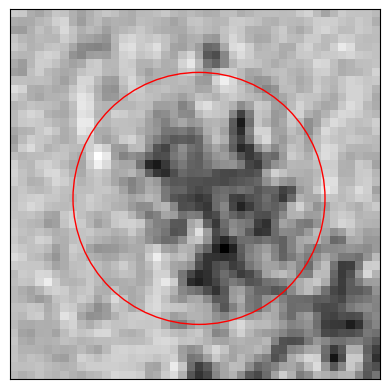

In [37]:
# {'x': 5106.838, 'y': 4835.263, 'z': 619.225}
plt.xticks([])
plt.yticks([])
circle = plt.Circle((22,22), radius=15, facecolor='none', edgecolor='r')
plt.gca().add_patch(circle)
_ = plt.imshow(z_ts_6_4[0][61, 461:505, 488:532], cmap='gray')

### Side View

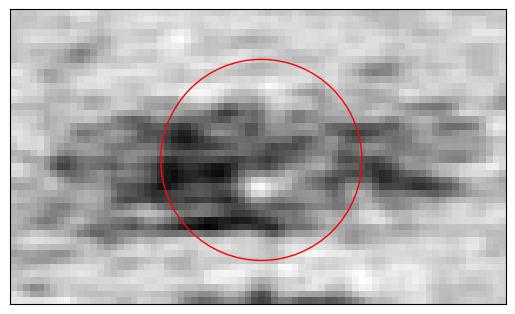

In [38]:
from matplotlib.patches import Circle
plt.xticks([])
plt.yticks([])
circle = plt.Circle((37,22), radius=15, facecolor='none', edgecolor='r')
plt.gca().add_patch(circle)
_ = plt.imshow(np.transpose(z_ts_6_4[0], axes=(2,1,0))[510, 461:505, 24:98], cmap='gray')

### Top View

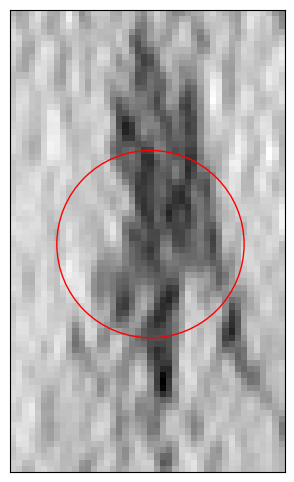

In [39]:
fig = plt.figure(figsize=(5,6))
plt.xticks([])
plt.yticks([])
circle = plt.Circle((22,37), radius=15, facecolor='none', edgecolor='r')
plt.gca().add_patch(circle)
_ = plt.imshow(np.transpose(z_ts_6_4[0], axes=(1,0,2))[483, 24:98, 488:532], cmap='gray')

## Make Training Crops

For the training crops, we can use the centroids, except where they are too close to the edge.  For that situation we might as well shift them across a bit first. And while we're at it, let's set aside a sensible number of crops of empty space from around our regions of interest, and call those 'empty'.

In [40]:
HALF = cfg.CROP_SIZE//2
df['x_v'] = round(df['x'] / cfg.ZARR_SCALE).astype(int).clip(lower=HALF, upper=630-HALF) # 8 - 622
df['y_v'] = round(df['y'] / cfg.ZARR_SCALE).astype(int).clip(lower=HALF, upper=630-HALF) # 8 - 622
df['z_v'] = round(df['z'] / cfg.ZARR_SCALE).astype(int).clip(lower=HALF, upper=184-HALF) # 8 - 176
df['x_start'], df['x_end'] = df['x_v'] - HALF, df['x_v'] + HALF
df['y_start'], df['y_end'] = df['y_v'] - HALF, df['y_v'] + HALF
df['z_start'], df['z_end'] = df['z_v'] - HALF, df['z_v'] + HALF
df.head()

,sample_id,object_type,x,y,z,Size (A),Size (V),Vol (V3),x_v,y_v,z_v,x_start,x_end,y_start,y_end,z_start,z_end
0,TS_86_3,apo-ferritin,3870.343,4952.714,1261.600,60,6,113,387,495,126,379,395,487,503,118,134
1,TS_86_3,apo-ferritin,4130.897,5422.292,501.860,60,6,113,413,542,50,405,421,534,550,42,58
2,TS_86_3,apo-ferritin,2735.000,4668.447,520.291,60,6,113,273,466,52,265,281,458,474,44,60
3,TS_86_3,apo-ferritin,2649.615,4690.615,600.923,60,6,113,265,468,60,257,273,460,476,52,68
4,TS_86_3,apo-ferritin,2665.353,4810.641,612.019,60,6,113,266,480,61,258,274,472,488,53,69


In [41]:
def check_for_overlap(df, 
                      sample_id,
                      size,
                      proposal, 
                      overlap, 
                      scale):
    poi = df[['x_v', 'y_v', 'z_v']].to_numpy()   #existing points of interest
    difference = np.abs(poi -proposal)    #  - proposal   where proposal is a 3x1 array
    if np.any(np.all(difference < overlap, axis=1)):
        return None
    else:
        empty = {'sample_id': sample_id,
                 'object_type': 'empty',
                 'x': proposal[0] * scale,
                 'y': proposal[1] * scale,
                 'z': proposal[2] * scale,
                 'Size (A)': 100,
                 'Size (V)': 10,
                 'Vol (V3)': 100,
                 'x_v': proposal[0],
                 'y_v': proposal[1],
                 'z_v': proposal[2],
                 'x_start': proposal[0] - size // 2,  #eg 8 -> 0, with a block size of 16
                 'x_end': proposal[0] + size // 2,    #eg 8 -> 16,  with a block size of 16
                 'y_start': proposal[1] - size // 2,  
                 'y_end': proposal[1] + size // 2,
                 'z_start': proposal[2]  - size // 2,
                 'z_end': proposal[2]  + size // 2}
        return empty

def generate_proposal(x_lim, y_lim, z_lim, buffer, samples):
    x_p = np.random.randint(buffer, x_lim - buffer)
    y_p = np.random.randint(buffer, y_lim - buffer)
    z_p = np.random.randint(buffer, z_lim - buffer)
    sample = random.choice(samples)
    return np.array([x_p, y_p, z_p]), sample

empties=[]
while len(empties) < cfg.NUM_EMPTY:
    proposal, sample = generate_proposal(630, 630, 184, cfg.CROP_SIZE // 2, paths.TRAIN_NMS)
    empty = check_for_overlap(df, sample, 16, proposal, 10, cfg.ZARR_SCALE)
    if empty is not None:
        empties.append(empty)

empty_df = pd.DataFrame(empties)
empty_df.head(3)

,sample_id,object_type,x,y,z,Size (A),Size (V),Vol (V3),x_v,y_v,z_v,x_start,x_end,y_start,y_end,z_start,z_end
0,TS_69_2,empty,740.920856,790.983076,1291.605276,100,10,100,74,79,129,66,82,71,87,121,137
1,TS_86_3,empty,120.149328,3003.733200,760.945744,100,10,100,12,300,76,4,20,292,308,68,84
2,TS_6_6,empty,2843.534096,2733.397212,1752.177700,100,10,100,284,273,175,276,292,265,281,167,183


In [42]:
df = pd.concat([df, empty_df], ignore_index=True)

df['x_dif'] = df['x_end'] - df['x_start']
df['y_dif'] = df['y_end'] - df['y_start']
df['z_dif'] = df['z_end'] - df['z_start']

df.head(3)

,sample_id,object_type,x,y,z,Size (A),Size (V),Vol (V3),x_v,y_v,z_v,x_start,x_end,y_start,y_end,z_start,z_end,x_dif,y_dif,z_dif
0,TS_86_3,apo-ferritin,3870.343,4952.714,1261.600,60,6,113,387,495,126,379,395,487,503,118,134,16,16,16
1,TS_86_3,apo-ferritin,4130.897,5422.292,501.860,60,6,113,413,542,50,405,421,534,550,42,58,16,16,16
2,TS_86_3,apo-ferritin,2735.000,4668.447,520.291,60,6,113,273,466,52,265,281,458,474,44,60,16,16,16


In [43]:
df['x_dif'].unique()

array([16])

In [44]:
def process_tomo(sample, group, paths):
    '''Open the zarr file, access the highest resolution scan, and save the crop as Unsigned 8-bit integer'''
    tomo = zarr.open(str(paths.TRAIN_DN_ZARS[sample]), mode='r')
    slicing_cols = ['object_type','x_start', 'x_end', 'y_start', 'y_end', 'z_start', 'z_end']
    records = group[slicing_cols].to_dict(orient='records')
    print(f'{len(group)} record were found in sample {sample}')
    
    for idx, row in enumerate(records):
        crop = tomo[0][row['z_start']:row['z_end'],
                       row['y_start']:row['y_end'],
                       row['x_start']:row['x_end']]
        type=row['object_type']

        lower, upper = np.percentile(crop, (0.5, 99.5))
        clipped = np.clip(crop, lower, upper)
        scaled = ((clipped - lower) / (upper - lower + 1e-12) * 255).astype(np.uint8)
        np.save(paths.DESTN_FLDRS[type] / f'{sample}_{idx}.npy', scaled)
        
    
for sample_id, group in df.groupby('sample_id'):
    process_tomo(sample_id, group, paths)

npy_files = list(paths.RESULTS_FLDR.rglob('*.npy'))
print(f'{len(npy_files)} files were saved as numpy arrays')

210 record were found in sample TS_5_4
220 record were found in sample TS_69_2
254 record were found in sample TS_6_4
202 record were found in sample TS_6_6
283 record were found in sample TS_73_6
308 record were found in sample TS_86_3
292 record were found in sample TS_99_9
1769 files were saved as numpy arrays


### Varify the crops

Now let's take a quick look at the result, just by examining some planes through the centre of the crop to get an idea if this is something the could looks like it could be classified.  I'll look seperately at each class.  The cell can be re-run to generate a new random example.

In [45]:
def plot_random_cube(path, size):
    crop = np.load(path)
    cube_type = Path(path).parent.name  # Assuming `path` is a Path object
    slices = [
        (crop[0, :, :], 'Slice 0 along z axis'),
        (crop[1, :, :], 'Slice 1 along z axis'),
        (crop[2, :, :], 'Slice 2 along z axis'),
        (crop[3, :, :], 'Slice 3 along z axis'),
        (crop[4, :, :], 'Slice 4 along z axis'),
        (crop[5, :, :], 'Slice 5 along z axis'),
        (crop[6, :, :], 'Slice 6 along z axis'),
        (crop[7, :, :], 'Slice 7 along z axis'),
        (crop[8, :, :], 'Slice 8 along z axis'),
        (crop[9, :, :], 'Slice 9 along z axis'),
        (crop[:, 3, :], 'Slice 3 along y axis'),
        (crop[:, :, 3], 'Slice 3 along x axis')
    ]
    
    fig, axes = plt.subplots(3, 4, figsize=(10, 10))
    axes = axes.flat
    
    for ax, (slice_data, title) in zip(axes, slices):
        ax.imshow(slice_data, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    text = f'Plotting a sample of {cube_type}, with shape {crop.shape}'
    fig.suptitle(text, fontsize=14)
    plt.show()

In [46]:
paths.DESTN_FLDRS['apo-ferritin']

PosixPath('/kaggle/working/apo-ferritin')

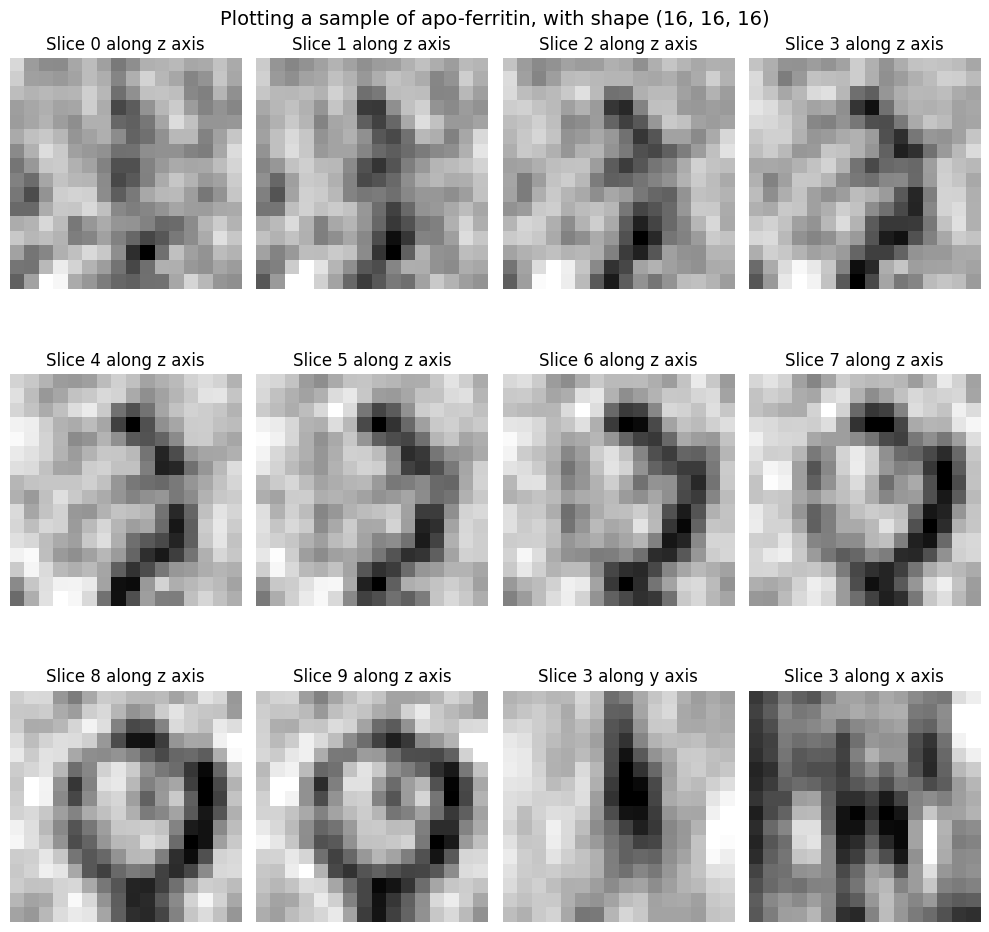

In [47]:
apo_ferritins = list(paths.DESTN_FLDRS['apo-ferritin'].rglob('*.npy'))
random_apo = random.choice(apo_ferritins)
plot_random_cube(random_apo, 16)

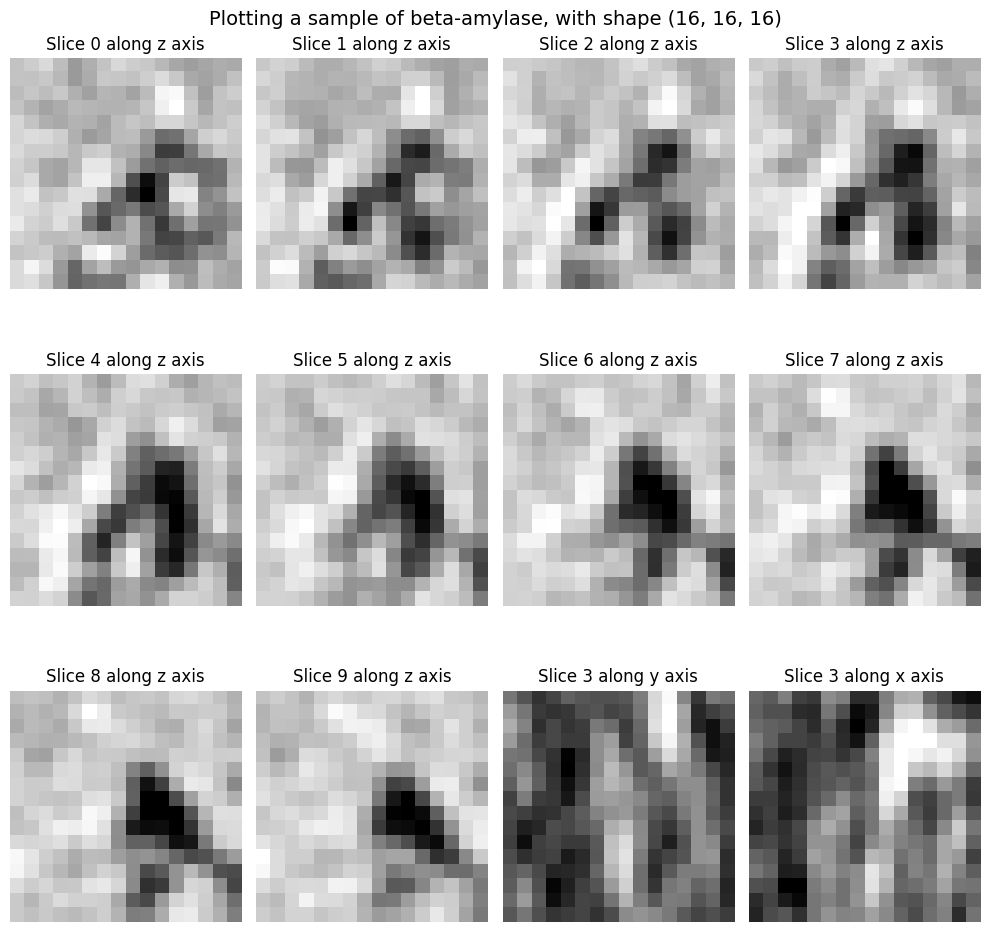

In [48]:
betas = list(paths.DESTN_FLDRS['beta-amylase'].rglob('*.npy'))
random_file = random.choice(betas)
plot_random_cube(random_file, 16)

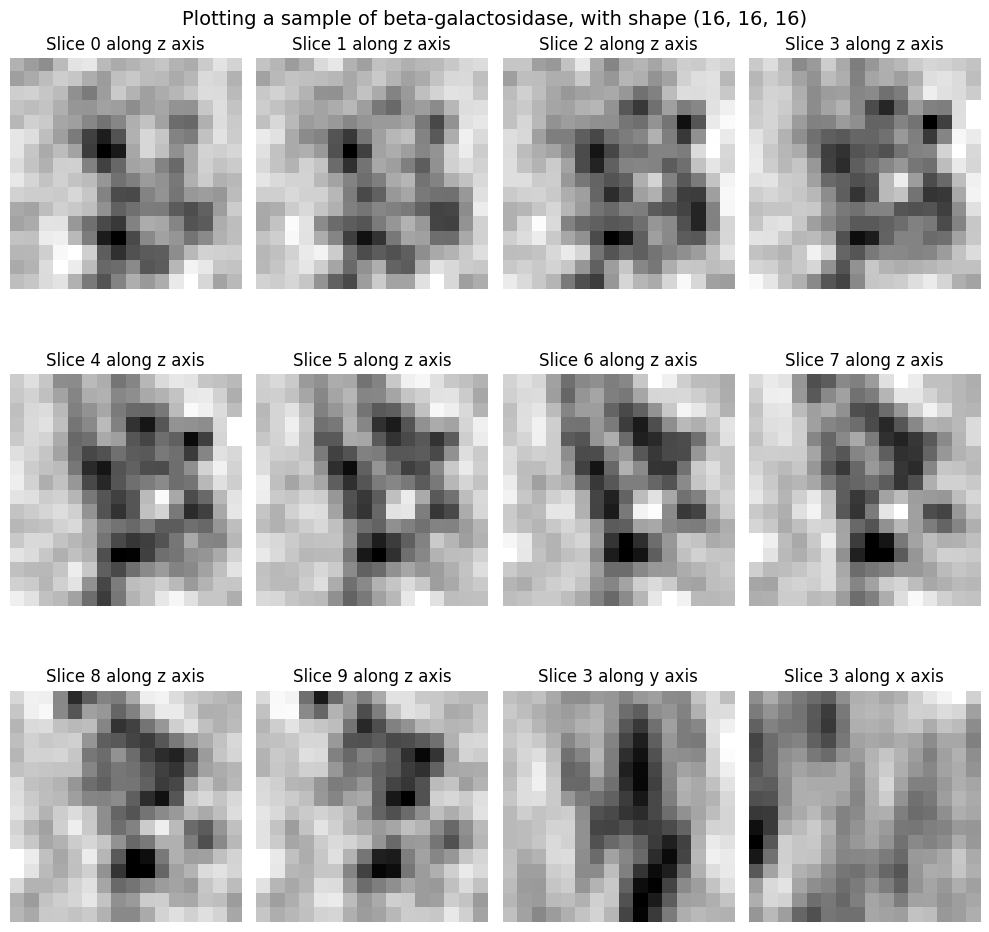

In [49]:
beta_gs = list(paths.DESTN_FLDRS['beta-galactosidase'].rglob('*.npy'))
random_file = random.choice(beta_gs)
plot_random_cube(random_file, 16)

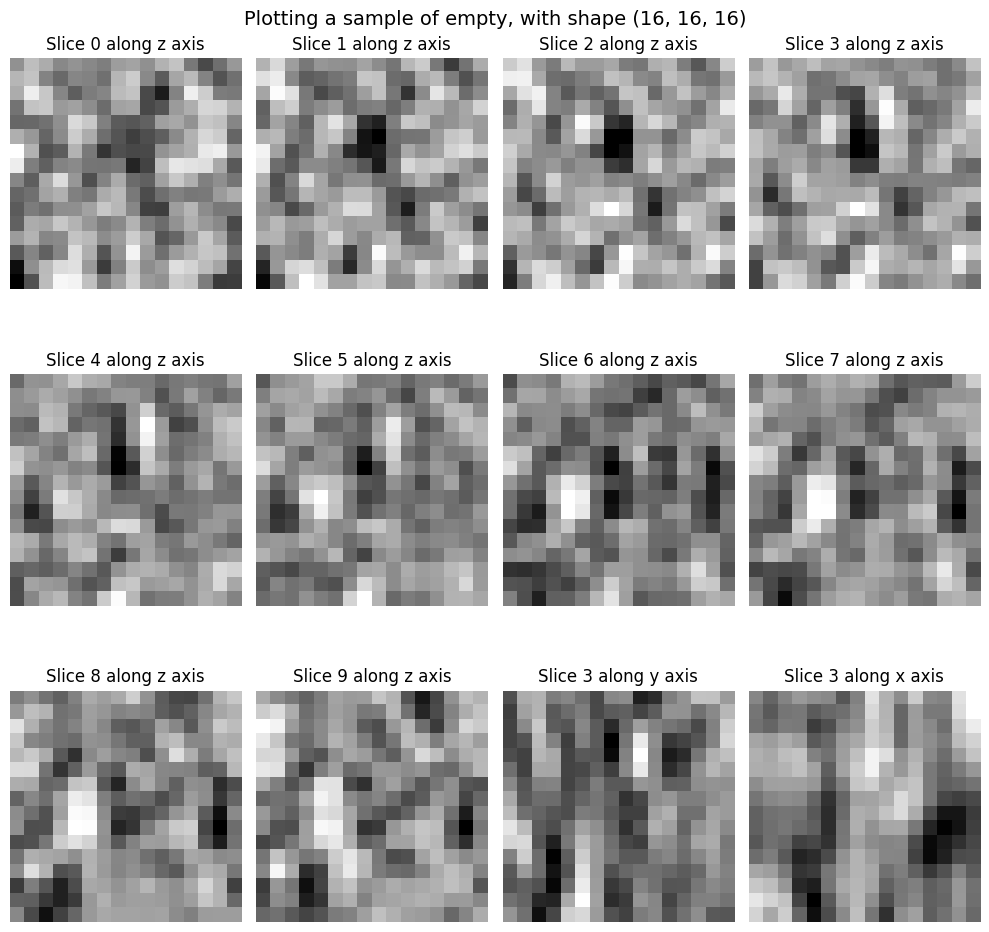

In [50]:
empties = list(paths.DESTN_FLDRS['empty'].rglob('*.npy'))
random_file = random.choice(empties)
plot_random_cube(random_file, 16)

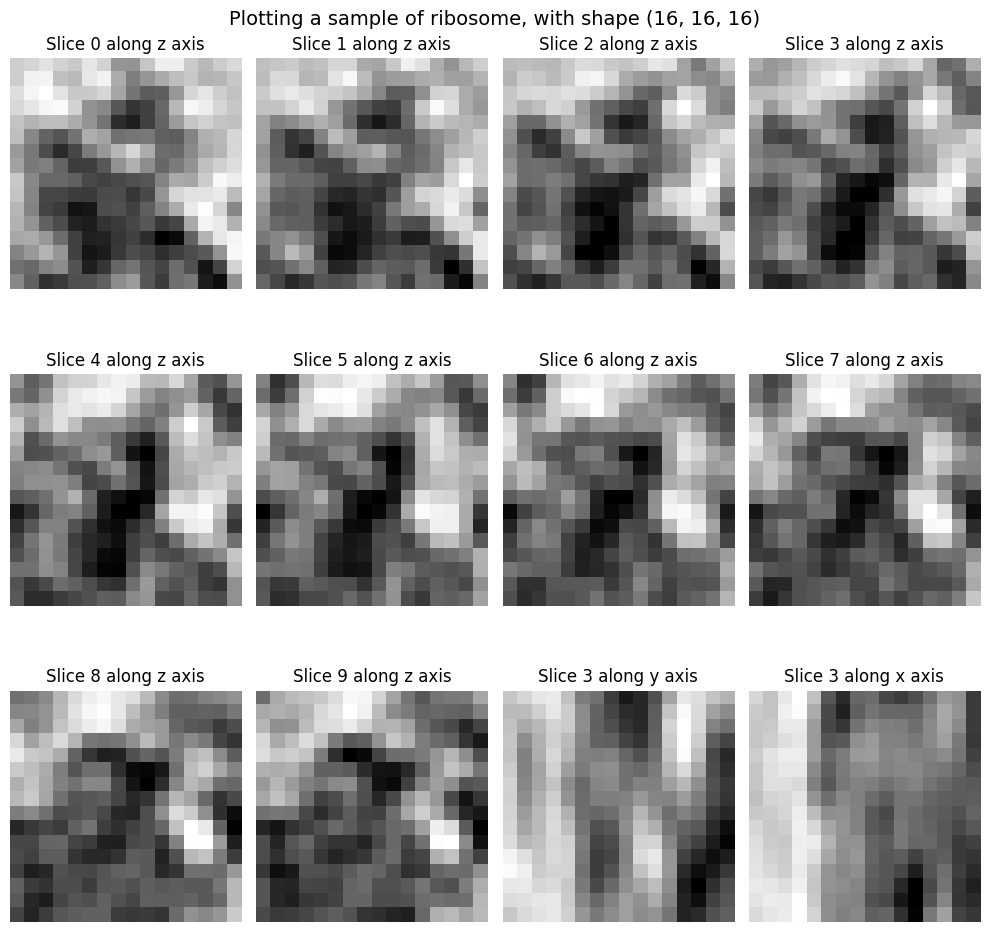

In [51]:
ribosome = list(paths.DESTN_FLDRS['ribosome'].rglob('*.npy'))
random_file = random.choice(ribosome)
plot_random_cube(random_file, 16)

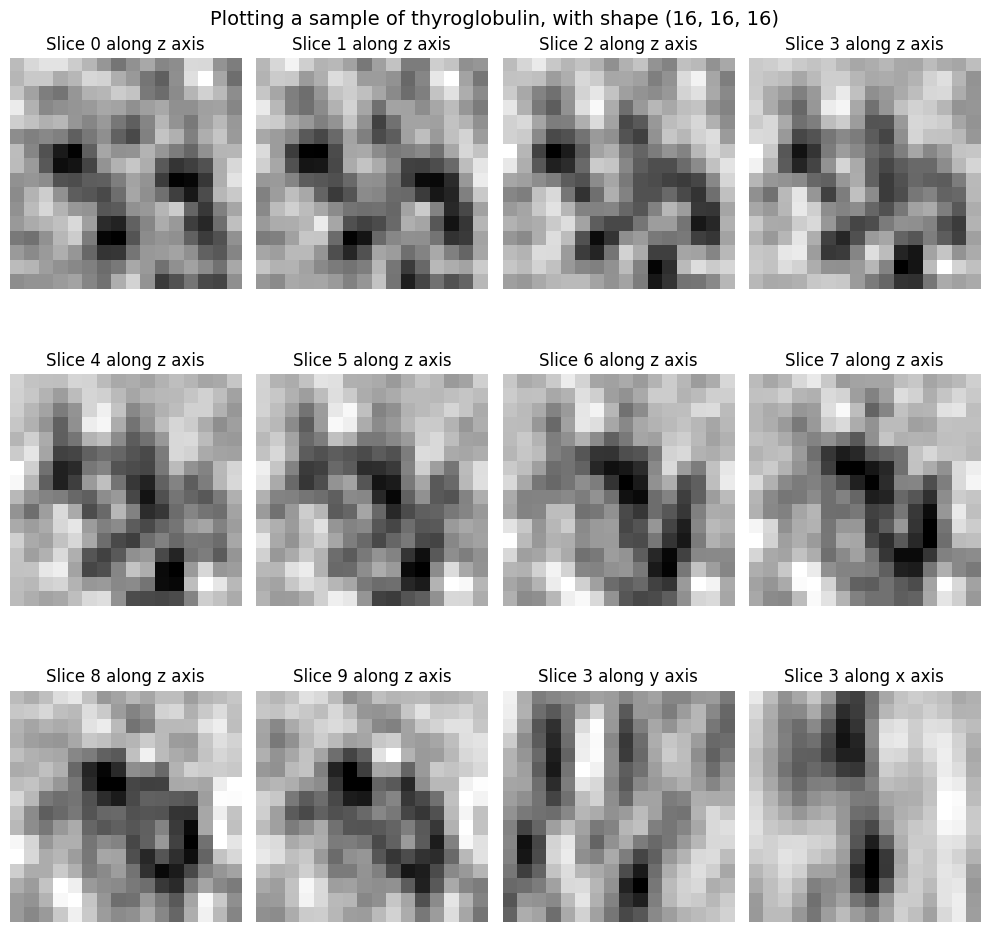

In [52]:
thyros = list(paths.DESTN_FLDRS['thyroglobulin'].rglob('*.npy'))
random_file = random.choice(thyros)
plot_random_cube(random_file, 16)

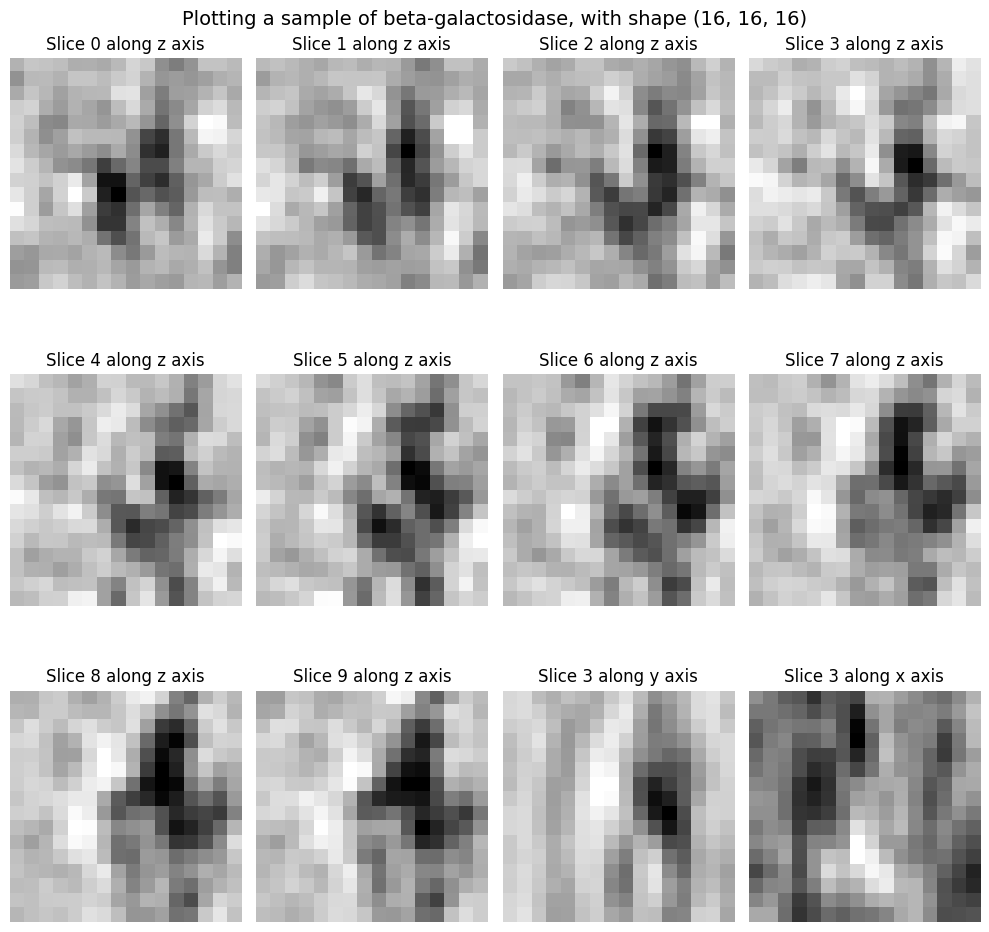

In [53]:
virus = list(paths.DESTN_FLDRS['beta-galactosidase'].rglob('*.npy'))
random_file = random.choice(virus)
plot_random_cube(random_file, 16)

## Conclusion

- It remains to be seen whether single-stage classification, like U-Net or YOLO,  will out-perform a two stage concepts like I'm working on here.  But there is potentially a huge efficiency advantage to building very small models just on proposed regions of interest, rather than uniformly classifying the whole volume.
- Looking through the above cells a few times, it looks like most, but often not quite all the particles are covered by 16x16x16 crops.  But it would be a good idea to re-visit larger crop sizes too.
- It isn't all that clear just from inspecting like this how best to make best use of the 3d nature of these scans.  I will leave that for experimentation.
- The dataset is reasonably well balanced, but smaller than I'm familiar with from past projects.  Augmentation will likely be very important for this competition.
- As was noted in [David's original notebook](https://www.kaggle.com/code/davidlist/experiment-ts-6-4-visualization), there is elongation in the z axis.  See discussion here: [https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/545742](https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/545742)

Thanks to David, and others for their great visualisations so far.   This is my first foray into medical physics.  It seems to be quite a difficult to get startarted, but a fascinating competition to understand properly.  Good luck to all.